In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from os.path import join, basename, dirname
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from natsort import natsorted
from tqdm import tqdm
import torch

from torchvision.io import read_image
from torchvision.utils import make_grid
from torchvision import transforms

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from experiment_utils import set_env, REPO_PATH, seed_everything
set_env()

In [5]:
from image_utils import denormalize, show_single_image, show_multiple_images
from cgn_framework.imagenet.dataloader import get_imagenet_dls
from cgn_framework.imagenet.models.classifier_ensemble import InvariantEnsemble
from cgn_framework.imagenet.models import CGN
from experiments.imagenet_utils import (
    EnsembleGradCAM,
    get_imagenet_mini_foldername_to_classname,
)
from experiments.gradio_demo import in_mini_folder_to_class

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

### Load CGN model

In [7]:
seed_everything(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# load data
print("Loading data ...")
train_loader, val_loader, train_sampler = get_imagenet_dls(
    "imagenet/data/in-mini", False, 64, 10,
)
ds_val = val_loader.dataset

Loading data ...


In [9]:
ds_val = val_loader.dataset
df = pd.DataFrame(None, columns=["sample_index", "class_index", "class_folder", "class_name"])
df["sample_index"] = list(range(len(ds_val.labels)))
df["class_index"] = ds_val.labels.astype(int)
df["class_folder"] = df["class_index"].apply(lambda x: ds_val.classes[x])
df["class_name"] = df["class_folder"].replace(in_mini_folder_to_class)

In [10]:
# load CGN model
print("Loading CGN model ...")
cgn = CGN(batch_sz=1, pretrained=False)
weights = torch.load(join(REPO_PATH, 'cgn_framework/imagenet/weights/cgn.pth'), map_location='cpu')
cgn.load_state_dict(weights)
cgn.eval().to(device);

Loading CGN model ...


In [11]:
def generate(ys):
    
    clf_transforms=ds_val.T_ims

    with torch.no_grad():
        x_gt, mask, premask, foreground, background, bg_mask = cgn(ys=ys)
        x_gen = mask * foreground + (1 - mask) * background

    image = x_gen[0]
    pil_image = transforms.ToPILImage()((image + 1) * 0.5)
    transformed_image = clf_transforms(pil_image)

    foreground = foreground[0]
    foreground = transforms.ToPILImage()((foreground + 1) * 0.5)
    foreground = clf_transforms(foreground)
    
    mask = mask[0]

    background = background[0]
    background = transforms.ToPILImage()((background + 1) * 0.5)
    background = clf_transforms(background)

    result = {
        "x_gen": transformed_image,
        "mask": mask,
        "premask": premask,
        "fg": foreground,
        "bg": background,
    }
    return result

In [12]:
def display_generated_sample(result, save=False, save_name="sample"):
    fig, axes = plt.subplots(1, 4, figsize=(11, 3), constrained_layout=True)

    keys_to_show = ["mask", "fg", "bg", "x_gen"]
    titles = ["Shape", "Texture", "Background", "Counterfactual"]

    show_single_image(result["mask"], normalized=False, ax=axes[0], title=titles[0], show=False, cmap="gray")
    show_single_image(result["fg"], normalized=True, ax=axes[1], title=titles[1], show=False)
    show_single_image(result["bg"], normalized=True, ax=axes[2], title=titles[2], show=False)
    show_single_image(result["x_gen"], normalized=True, ax=axes[3], title=titles[3], show=False)
    
    
    if save:
        plt.savefig(join(REPO_PATH, f"experiments/results/plots/{save_name}.pdf"))
    plt.show()

In [13]:
def convert_list_of_classes_into_indices(class_names):
    mapping = dict(df[["class_name", "class_index"]].values)
    return [mapping[c] for c in class_names]

In [14]:
result = generate([0, 1, 2])

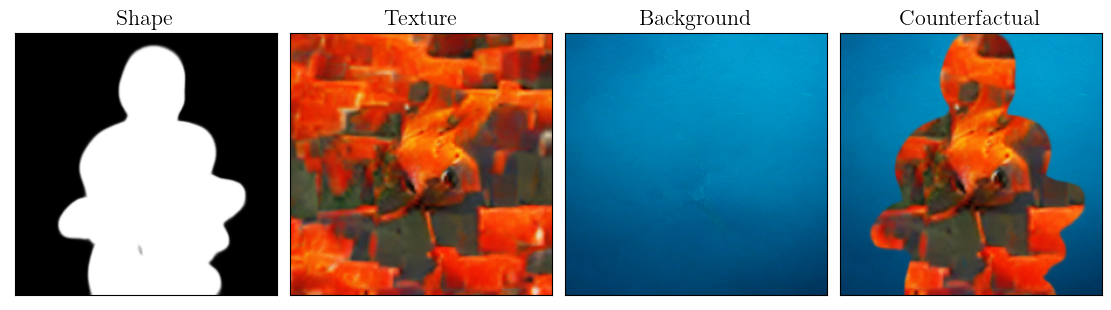

In [15]:
display_generated_sample(result)

### Textures

**Failure modes of CGN: Insufficient disentanglement**

1. Small objects in uniform backgrounds (e.g. `Kite in a sky` , `ski in snow`) struggle disentangling texture and background.
2. Cases where the central object has a complex texture (e.g. `crossword puzzle`) also seems to struggle disentangling texture and background.
3. As one would expect, complex scenes (e.g. `confectionary`) does not produce faithfully disentangles the three aspects.

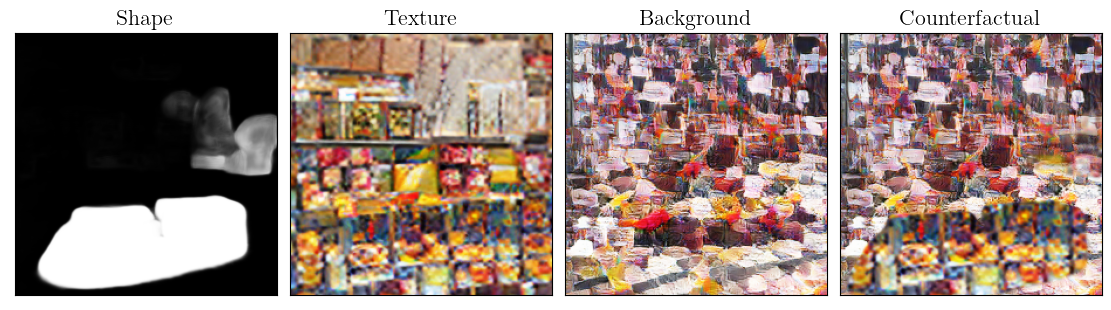

In [16]:
classes = ["hummingbird", "hummingbird", "hummingbird"]
classes = ["beagle", "beagle", "beagle"]
classes = ["kite", "kite", "kite"]
classes = ["hand-held computer" for _ in range(3)]
classes = ["ski" for _ in range(3)]
classes = ["shopping basket" for _ in range(3)]
classes = ["street sign" for _ in range(3)]
classes = ["crossword puzzle" for _ in range(3)]
classes = ["confectionery" for _ in range(3)]

ys = convert_list_of_classes_into_indices(classes)

display_generated_sample(generate(ys), save=True, save_name=f"cf_sample_{classes[0]}")

In [17]:
"hummingbird" in df.class_name.unique()

True

In [18]:
df.class_name.unique()

array(['tench', 'goldfish', 'great white shark', 'tiger shark',
       'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich',
       'brambling', 'goldfinch', 'house finch', 'junco', 'indigo bunting',
       'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel',
       'kite', 'bald eagle', 'vulture', 'great grey owl',
       'European fire salamander', 'common newt', 'eft',
       'spotted salamander', 'axolotl', 'bullfrog', 'tree frog',
       'tailed frog', 'loggerhead', 'leatherback turtle', 'mud turtle',
       'terrapin', 'box turtle', 'banded gecko', 'common iguana',
       'American chameleon', 'whiptail', 'agama', 'frilled lizard',
       'alligator lizard', 'Gila monster', 'green lizard',
       'African chameleon', 'Komodo dragon', 'African crocodile',
       'American alligator', 'triceratops', 'thunder snake',
       'ringneck snake', 'hognose snake', 'green snake', 'king snake',
       'garter snake', 'water snake', 'vine snake', 'night snake',
     